# Autoregressive HMM on example mouse

In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import seaborn as sns
from collections import defaultdict
import pandas as pd

from one.api import ONE
from jax import vmap
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
# from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from fitting_functions import cross_validate_armodel, compute_inputs
from plotting_functions import plot_transition_mat, plot_states_aligned, params_to_df, align_bin_design_matrix, states_per_trial_phase, plot_states_aligned_trial, traces_over_sates


# Custom functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from one_functions_generic import prepro

one = ONE()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Parameters

In [2]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
#data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']
       # var_names = ['avg_wheel_vel', 'whisker_me']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

List available mice

In [3]:
# Save data of all sessions for latter
mouse_names = []

for m, mat in enumerate(design_matrices):
    
    mouse_name = design_matrices[m][51:-4]
    if m == 0:
        mouse_names = mouse_name
    else:
        mouse_names = np.hstack((mouse_names, mouse_name))

## Preprocess list of design matrices

- Each session is saved under the mouse name; concatenated with other sessions of the same mouse;
- Only data up to trial 90 is kept;
- Data is normalized and standardized

In [4]:

# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for mouse_name in mouse_names:
    for m, mat in enumerate(design_matrices):
        
        if (mouse_name in mat) & (len(mouse_name) > 0): 
            
            # Trials data
            session = design_matrices[m][14:50]
                
            session_trials = one.load_object(session, obj='trials', namespace='ibl')
            session_trials = session_trials.to_df()
            session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
            session_start = list(session_trials['stimOn_times'])[0]

            # Get time of last unbiased trial
            unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
            time_trial_90 = list(unbiased['stimOff_times'])[-1]
            
            big_design_matrix = pickle.load(open(mat, "rb"))
            design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
            design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
            design_matrix = design_matrix.dropna()
        
            # Keep only first 90 trials
            design_matrix = design_matrix.loc[(design_matrix['Bin'] < time_trial_90 * 10) & (design_matrix['Bin'] > session_start * 10)]
            unbiased_trials = session_trials.loc[session_trials['stimOff_times'] < time_trial_90]
            training_set = np.array(design_matrix[var_names]).copy() 
            
            if len(training_set) > 0:
                # Standardization using StandardScaler
                scaler = StandardScaler()
                standardized = scaler.fit_transform(training_set)
                # Normalize between 0 and 1
                normalizer = Normalizer().fit(standardized)
                normalized = normalizer.transform(standardized)
            
            # Save results per mouse
            matrix_all[mouse_name].append(normalized)
            session_all[mouse_name].append(unbiased_trials)    
            matrix_all_unnorm[mouse_name].append(design_matrix) 
            
# Collapse multiple sessions per mouse
for mouse in np.unique(mouse_names):
    if len(np.where(mouse_names==mouse)[0]) > 1 and len(mouse) > 0:
        matrix_all[mouse] = np.vstack(matrix_all[mouse])
        matrix_all_unnorm[mouse] = np.vstack(matrix_all_unnorm[mouse])
        session_all[mouse] = pd.concat(session_all[mouse], ignore_index=True)

## Parameters

In [5]:
num_iters = 100
num_train_batches = 5
method = 'kmeans'

# Plotting params
bin_size = 0.1
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

## Fit Autoregressive HMM

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


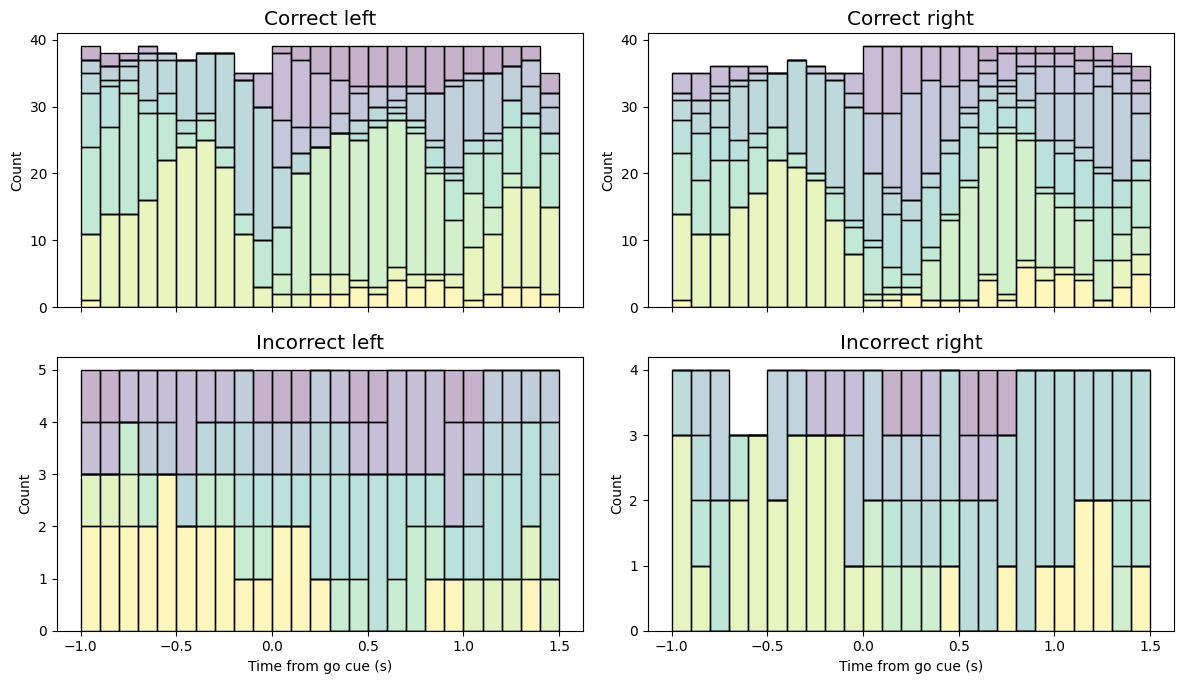

/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:293: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:295: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

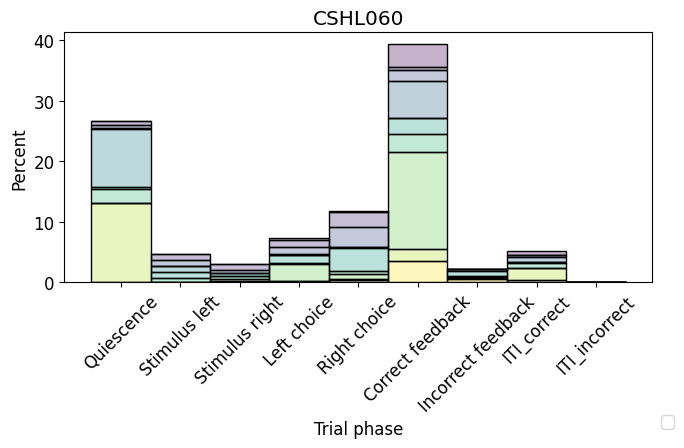

/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


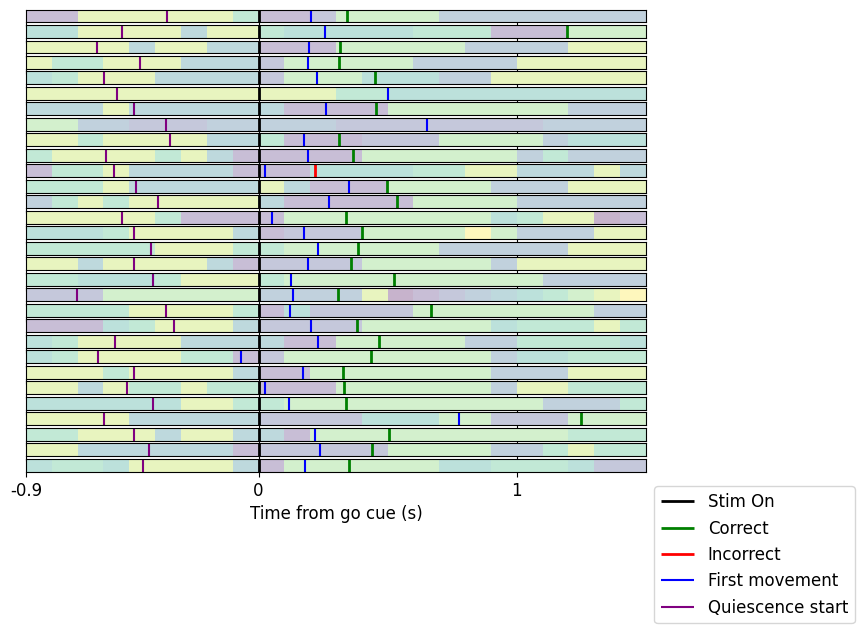

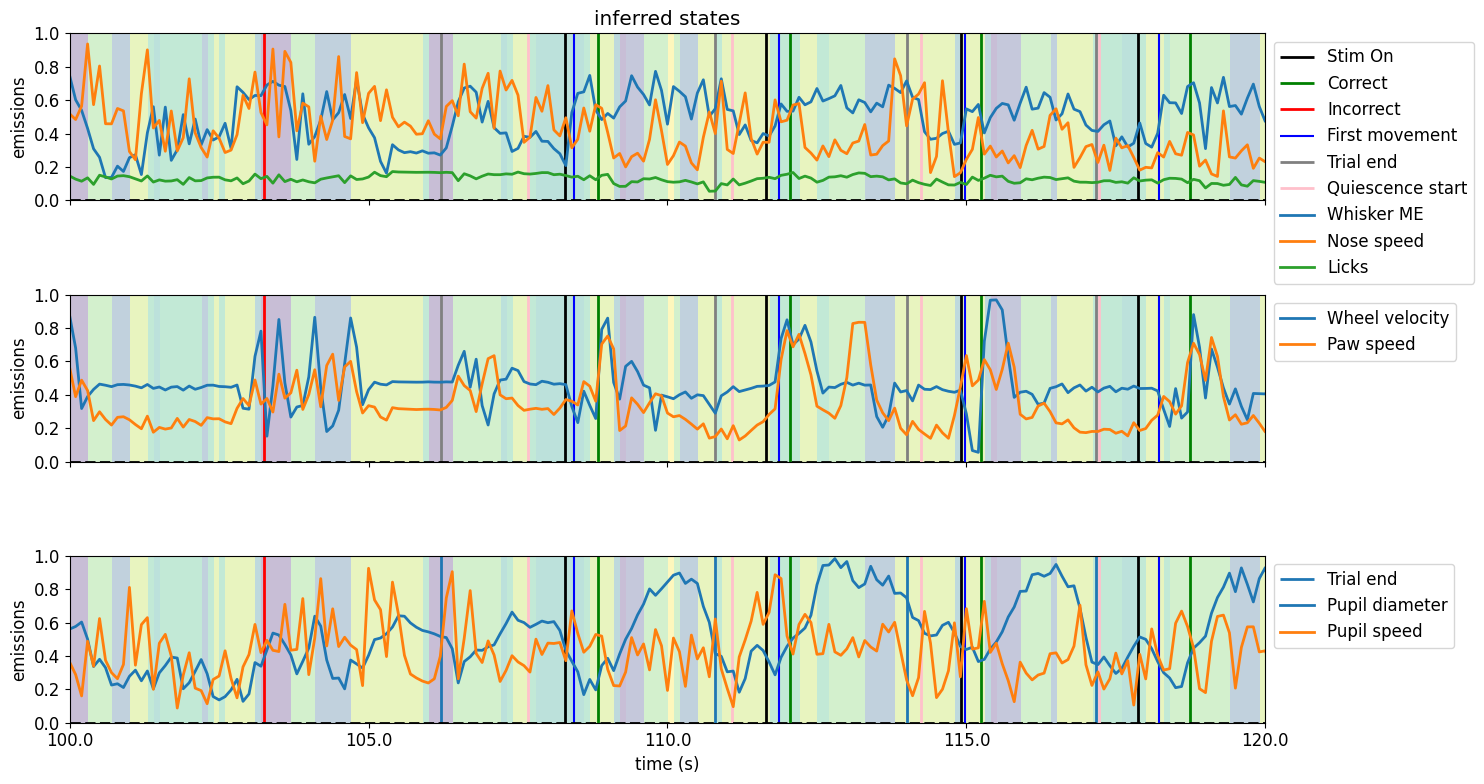

2.0


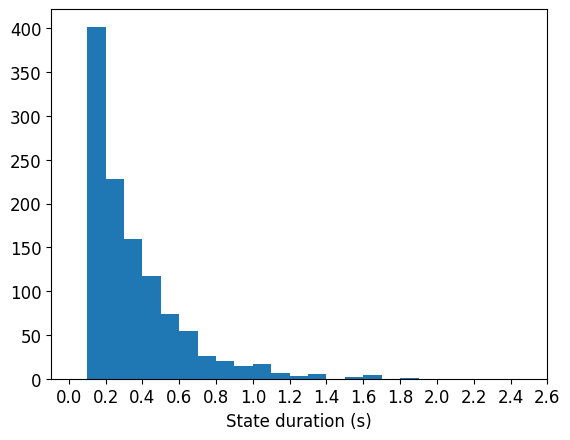

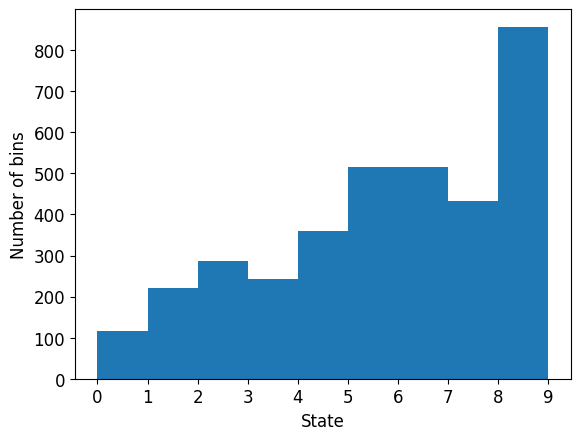

In [6]:
filename = open('best_results', 'rb')
best_fits = pickle.load(filename)

# Loop through mice
for m, mouse_name in enumerate(np.unique(mouse_names)[0:2]):
    if len(mouse_name) > 0:
        
        order = np.where(best_fits['mouse_names']==mouse_name)[0]
        num_states = int(best_fits['best_state'][order][0])
        num_lags = int(best_fits['best_lag'][order][0])
        
        # Get mouse data
        session_trials = session_all[mouse_name]
        design_matrix = matrix_all[mouse_name]
        unnorm_mat = matrix_all_unnorm[mouse_name]  
        
        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            unnorm_mat = matrix_all_unnorm[mouse_name][0]
            
        " Fit model with cross-validation"
        # Prepare data for cross-validation
        num_timesteps = np.shape(design_matrix)[0]
        emission_dim = np.shape(design_matrix)[1]
        shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
        train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
        
        # Initialize model with Kmeans
        test_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags, transition_matrix_stickiness=100.)
        init_params, props = test_arhmm.initialize(key=jr.PRNGKey(1), method=method, emissions=shortened_array)  # for now all data
        
        # Compute inputs for required timelags
        my_inputs = compute_inputs(shortened_array, num_lags, emission_dim)
        train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))
        
        # Fit model to all data with cross-validation
        val_lls, fit_params, init_params, baseline_lls = cross_validate_armodel(test_arhmm, 
                                                                              jr.PRNGKey(0), shortened_array, train_emissions, train_inputs, method, num_train_batches)

        " Re-fit with parameters of best fold "
        # Find best fold
        use_fold = np.where(val_lls==np.nanmax(val_lls))[0][0]
        print(use_fold)
        
        # Find parameters for best fold
        initial_probs = fit_params[0].probs[use_fold]
        transition_matrix = fit_params[1].transition_matrix[use_fold]
        emission_weights = fit_params[2].weights[use_fold]
        emission_biases = fit_params[2].biases[use_fold]
        emission_covariances = fit_params[2].covs[use_fold]        
        
        # Initialize new hmm
        new_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
        best_fold_params, props = new_arhmm.initialize(key=jr.PRNGKey(0), method=method,
                                        initial_probs=initial_probs,
                                        transition_matrix=transition_matrix,               
                                        emission_weights=emission_weights,
                                        emission_biases=emission_biases, 
                                        emission_covariances=emission_covariances,
                                        emissions=shortened_array)  # not sure if I need to include  

        # Get state estimates for validation data
        most_likely_states = new_arhmm.most_likely_states(best_fold_params, shortened_array, my_inputs)

        " Plots "
        # Prepare data
        design_matrix_heading = pd.DataFrame(columns=var_names)
        design_matrix_heading[var_names] = design_matrix[0:len(most_likely_states)]  # TODO: need to understand why number is the same and whether it depends on lag
        bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
        design_matrix_heading['Bin'] = bins
        init = -10
        end = 15
        empirical_data = align_bin_design_matrix(init, end, event_type_list, session_trials, design_matrix_heading, most_likely_states, multiplier)

        " Plot states stacked and aligned per trial type "
        plot_states_aligned(init, end, empirical_data, event_type_name, bin_size)
        
        """ Plot states per trial epoch """
        colors = sns.color_palette("viridis", num_states)
        states_trial = states_per_trial_phase(empirical_data, session_trials)
        plt.figure(figsize=[7, 5])
        sns.histplot(x='label', hue=0, data=states_trial, stat = 'percent',
                            multiple="stack", legend=True, palette='viridis', alpha=0.3)  # stat='frequency',
        plt.xlabel('Trial phase')
        plt.legend(loc='upper left', bbox_to_anchor=(1, -0.5))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.title(mouse_name)
        plt.show()
    
        """ Stack trial states """
        trial_init = 10  # First trial to plot
        trials_to_plot = 30  # How many trials to plot (if very different will compromise readibility)
        plot_states_aligned_trial(trial_init, empirical_data, session_trials, bin_size, trials_to_plot, num_states)
        
        """ Plot raw traces over states """
        init = 1000 # First bin
        traces_over_sates(init, empirical_data, most_likely_states, session_trials, var_names)
        
        
        # plt.imshow(np.mean(fit_params[1].transition_matrix, axis=0), vmin=0, vmax=1, cmap="Greys")
        # plt.xlabel("next state")
        # plt.ylabel("current state")
        # plt.title("transition matrix")
        # plt.colorbar()
        
        " Plot state durations "
        dif = np.diff(most_likely_states)
        jump = np.where(dif != 0)
        jump_dif = np.diff(jump)
        print(np.nanmedian(jump_dif))
        bins = np.arange(0, 20, 1)
        plt.hist(jump_dif[0], bins)
        plt.xticks(np.arange(0, np.max(jump_dif[0]), 2), np.arange(0, np.max(jump_dif[0]), 2)/10)
        # plt.xlim([0, 20])
        plt.xlabel('State duration (s)')
        plt.show()
        
        " Plot state frequency "
        bins = np.arange(0, num_states, 1)
        plt.hist(most_likely_states, bins)
        plt.xlabel('State')
        plt.xticks(np.arange(0, np.max(most_likely_states), 1), np.arange(0, np.max(most_likely_states), 1))
        plt.ylabel('Number of bins')
        plt.xticks(np.arange(0, num_states, 1), np.arange(0, num_states, 1))
        #plt.title(ses)
        plt.show()

        

In [8]:
session_trials
empirical_data
most_likely_states
design_matrix_heading


,avg_wheel_vel,pupil_diameter,whisker_me,nose_speed,l_paw_speed,left_X,left_Y,pupil_speed,pupil_X,pupil_Y,Lick count,Bin,most_likely_states,new_bin,correct,choice
0,-0.063133,-0.028701,-0.497098,-0.209638,-0.189836,0.203743,0.183770,-0.229468,0.163566,-0.713935,-0.060850,929.0,1,0.0,1.0,right
1,-0.073148,-0.072493,-0.564167,-0.124308,-0.169073,0.219017,0.198939,-0.562434,0.163808,-0.438161,-0.066154,930.0,4,1.0,1.0,right
2,-0.068723,-0.198143,-0.513545,-0.212125,-0.093390,0.196920,0.179921,-0.260355,0.118619,-0.694005,-0.062625,931.0,4,2.0,1.0,right
3,-0.122108,-0.354138,-0.024392,-0.180326,-0.008359,0.203226,0.183428,-0.192528,0.111420,-0.835082,-0.068579,932.0,1,3.0,1.0,right
4,-0.274821,-0.399705,0.036075,0.075450,0.101145,0.121362,0.086521,-0.343409,0.098726,-0.770014,-0.068359,933.0,1,4.0,1.0,right
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3540,-0.864103,0.094793,0.382676,-0.108620,-0.070713,-0.034106,-0.164129,0.132911,0.133515,-0.107387,-0.077299,4525.0,5,NaN,NaN,NaN
3541,-0.274290,0.135946,0.273483,0.677757,-0.050139,-0.033234,-0.406744,0.040844,-0.241305,-0.372170,-0.068340,4526.0,5,NaN,NaN,NaN
3542,0.670808,0.095355,0.323730,0.091693,0.279309,-0.015527,-0.225682,0.052136,-0.304507,-0.446017,-0.064457,4527.0,5,NaN,NaN,NaN
3543,0.560680,0.061579,0.530856,0.061348,0.333473,0.016352,-0.247429,-0.024464,-0.110615,-0.454252,-0.066348,4528.0,5,NaN,NaN,NaN
